Date Created: 12/01/20
## Goal of Notebook: Visualize Gene Dependencies and Ordering on a Specific Genome
Since this project is largely motivated to do edits on a specific genome we want to be able to make a visual guide for genome editors to looks at.

In [36]:
import pandas as pd
from random import sample 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns                                                             
import sys 
import plotly.graph_objects as go
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Load in Genes and Phages dataframes

In [37]:
df_phages = pd.read_csv("data/phage_metadata.csv")
df_phages.head()

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
0,20ES,True,A,A2,SIPHO,Mycobacterium,smegmatis,53124.0,False,True,63.4
1,244,True,E,NaN,SIPHO,Mycobacterium,smegmatis,74483.0,True,True,63.4
2,32HC,True,Z,NaN,SIPHO,Mycobacterium,smegmatis,50781.0,False,True,65.7
3,39HC,False,B,B6,SIPHO,Mycobacterium,smegmatis,71565.0,False,True,70.0
4,40AC,True,A,A17,SIPHO,Mycobacterium,smegmatis,53396.0,False,True,63.3


In [38]:
df_genes = pd.read_csv("data/cleaned_gene_list.csv")
df_genes.head()

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
0,20ES_CDS_1,36676,NKF,MYGTRSSAFWASQPGKFDVLNLRMTFPSTSAHEIPDLTATDFVPEN...,F,20ES,1,NaN
1,20ES_CDS_10,39578,lysin b,MSLQVGSSGELVNRWIRVMKARFASYAGKLKEDGYFGLDDKAVQQE...,F,20ES,10,lysin b
2,20ES_CDS_11,34196,terminase,MSLENHHPELAPSPPHIIGPSWQRTVDGSWHLPDPKMTLGWGVLKW...,F,20ES,11,terminase
3,20ES_CDS_12,39511,portal protein,MTAPLPGQEEIPDPAIARDEMISAFDDAVKNLKINTSYYEAERRPE...,F,20ES,12,portal protein
4,20ES_CDS_13,21454,capsid maturation protease,MITAAVAAYVQRFASMFTGPALSLGEWARFLQTLFPEVQRRYAQAA...,F,20ES,13,capsid maturation protease


In [39]:
df_genes["pham"].nunique()

23224

load in synteny and dependency graphs

In [40]:
gene_identifier = "pham"
G_dep = nx.read_gml("networks/dependency_graph_"+ str(gene_identifier))
G_syn = nx.read_gml("networks/synteny_markov_graph_"+str(gene_identifier))

## Visualizations on a specific genome

In [41]:
# pick target genome for visualizations
target_phage = "D29"

In [42]:
# extract genome information from genes df
phage_genome = df_genes[df_genes["phage"] == target_phage].sort_values("gene number")
phage_genome.head(5)

,gene ID,pham,function,translation,orientation,phage,gene number,uncleaned function
71867,D29_CDS_1,36676,NKF,MYGTRSSAYWSTQPGKFDVLNLRMTFPSSSAYEIPDLRPTTYVPAN...,F,D29,1,NaN
71878,D29_CDS_2,14135,NKF,MDPAQKRAAFNALAVAARDQHSPSDAKRIAKRDQMLGYVRGPWEQL...,F,D29,2,NaN
71889,D29_CDS_3,9720,NKF,MALMQATHTIEGFLAVETHPRAFVAENGHVITRLSATKWGGWEGLE...,F,D29,3,NaN
71900,D29_CDS_4,38099,NKF,MSWAGSKRRQELPEDWELNYRLPVLSAAGWLCEVDGPGCVRAATDV...,F,D29,4,NaN
71911,D29_CDS_5,7918,NKF,MGTRGPIGKRDEERVRRNTPENPTETISMIGTVEIPELGDMSYMGE...,F,D29,5,NaN


In [43]:
df_phages[df_phages["phage"]==target_phage]

,phage,temperate,cluster,subcluster,morphotype,host genus,host species,genome length,is annotated,is phamerated,gcpercent
731,D29,True,A,A2,SIPHO,Mycobacterium,smegmatis,49136.0,True,True,63.5


### Graph Synteny on Genome
build network

In [44]:
# intialize graph
G = nx.DiGraph()

# position variables
pos = {}
x = 2
y = 1
fwd = True
num_row = 20
total_rows = np.ceil(phage_genome["gene number"].max()/num_row)

# iterate through genome and retrieve subset of synteny graph
for _, row in phage_genome.iterrows():
    # position logic
    pos[row["gene number"]] = [x,total_rows-y]
    if x > 0 and  x <= num_row and not fwd:
        x = x - 1
    elif x >= 0 and  x < num_row and fwd:
        x = x + 1
    elif x == 0:
        fwd = True
        y = y + 1
    elif x == num_row:
        fwd = False
        y = y + 1
    
    # create node
    curr_pham = str(row["pham"])
    G.add_node(row["gene number"], pham = curr_pham, function = row["function"])
    
    # add edge if in synteny network (which it should be)
    if row["gene number"] > 1 and G_syn.has_edge(previous_pham, curr_pham):
        G.add_edge(previous_gene_num, row["gene number"], weight = G_syn[previous_pham][curr_pham]["weight"])
    
    # record previous
    previous_gene_num = row["gene number"]
    previous_pham = curr_pham

Visualize above network

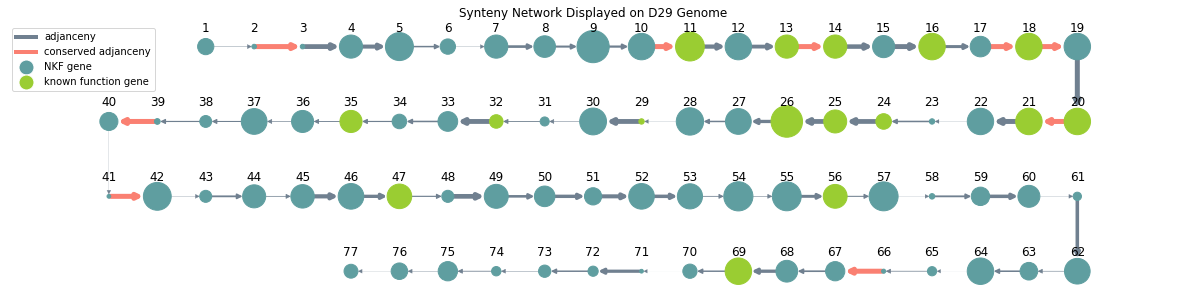

In [45]:
plt.figure(figsize = (num_row+1,total_rows+1))

node_size = [int(G_syn.nodes[G.nodes[i]["pham"]]["count"]) for i in G.nodes()]

nx.draw_networkx_edges(G, 
                       pos = pos, 
                       node_size = node_size,
                       width = [G[i][j]["weight"]*5 for i,j in G.edges()],
                       edge_color = ["salmon" if G[i][j]["weight"] == 1 and int(G_syn.nodes[G.nodes[i]["pham"]]["count"]) > 1 else "slategrey" for i,j in G.edges()])  
nx.draw_networkx_nodes(G, 
                       pos = pos, 
                       node_size = node_size,
                       node_color = ["yellowgreen" if G.nodes[i]["function"] != "NKF" else "cadetblue" for i in G.nodes()])   
nx.draw_networkx_labels(G, pos = {i:[arr[0], arr[1]+0.25] for i,arr in pos.items()})

legend_elements = [Line2D([0], [0], color="slategrey", lw=4, label='adjanceny'),
                   Line2D([0], [0], color="salmon", lw=4, label='conserved adjanceny'),
                   Line2D([0], [0], marker='o', color='w', label='NKF gene', markerfacecolor='cadetblue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='known function gene', markerfacecolor='yellowgreen', markersize=15)
                  ]

sns.despine(bottom=True, left = True)
plt.legend(handles=legend_elements, loc='upper left')

plt.title("Synteny Network Displayed on {} Genome".format(target_phage))
plt.show()


### Graph Gene Depedencies on Genome
Create network by extracting subset of network of gene dep

In [54]:
G = nx.DiGraph() # intialize graph

# iterate through all pairs of genes in target phage's genome
for _, row1 in phage_genome.iterrows():
    G.add_node(row1["gene number"], pham = str(row1["pham"]), function = row1["function"])
    pham1 = str(row1["pham"])
    gnum1 = row1["gene number"]
    for _, row2 in phage_genome.iterrows():
        pham2 = str(row2["pham"])
        gnum2 = row2["gene number"]
        #print(previous_pham, curr_pham)
        if gnum1 != gnum2 and G_dep.has_edge(pham1, pham2):
            G.add_edge(gnum1, gnum2, weight = G_dep.edges[pham1,pham2]["weight"])


Visualize above network

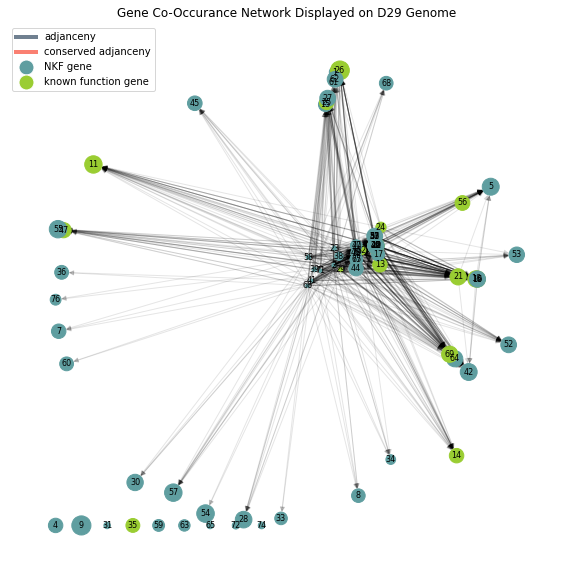

In [47]:
plt.figure(figsize = (10,10))
pos = nx.spring_layout(G, k = 0.05)

x = -1
for node, arr in pos.items():
    if G.degree(node) == 0:
        pos[node] = [x,-1]
        x = x+.1

node_size = [int(G_syn.nodes[G.nodes[i]["pham"]]["count"])**0.85 for i in G.nodes()]

nx.draw_networkx_edges(G, pos = pos, node_size = node_size, alpha = 0.1)  

nx.draw_networkx_nodes(G, 
                       pos = pos, 
                       node_size = node_size,
                      node_color = ["yellowgreen" if G.nodes[i]["function"] != "NKF" else "cadetblue" for i in G.nodes()]
                      )   

nx.draw_networkx_labels(G, pos = pos, font_size=8);

legend_elements = [Line2D([0], [0], color="slategrey", lw=4, label='adjanceny'),
                   Line2D([0], [0], color="salmon", lw=4, label='conserved adjanceny'),
                   Line2D([0], [0], marker='o', color='w', label='NKF gene', markerfacecolor='cadetblue', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='known function gene', markerfacecolor='yellowgreen', markersize=15)
                  ]

sns.despine(bottom=True, left = True)
plt.legend(handles=legend_elements, loc='upper left')
plt.title("Gene Co-Occurance Network Displayed on {} Genome".format(target_phage))

plt.show()

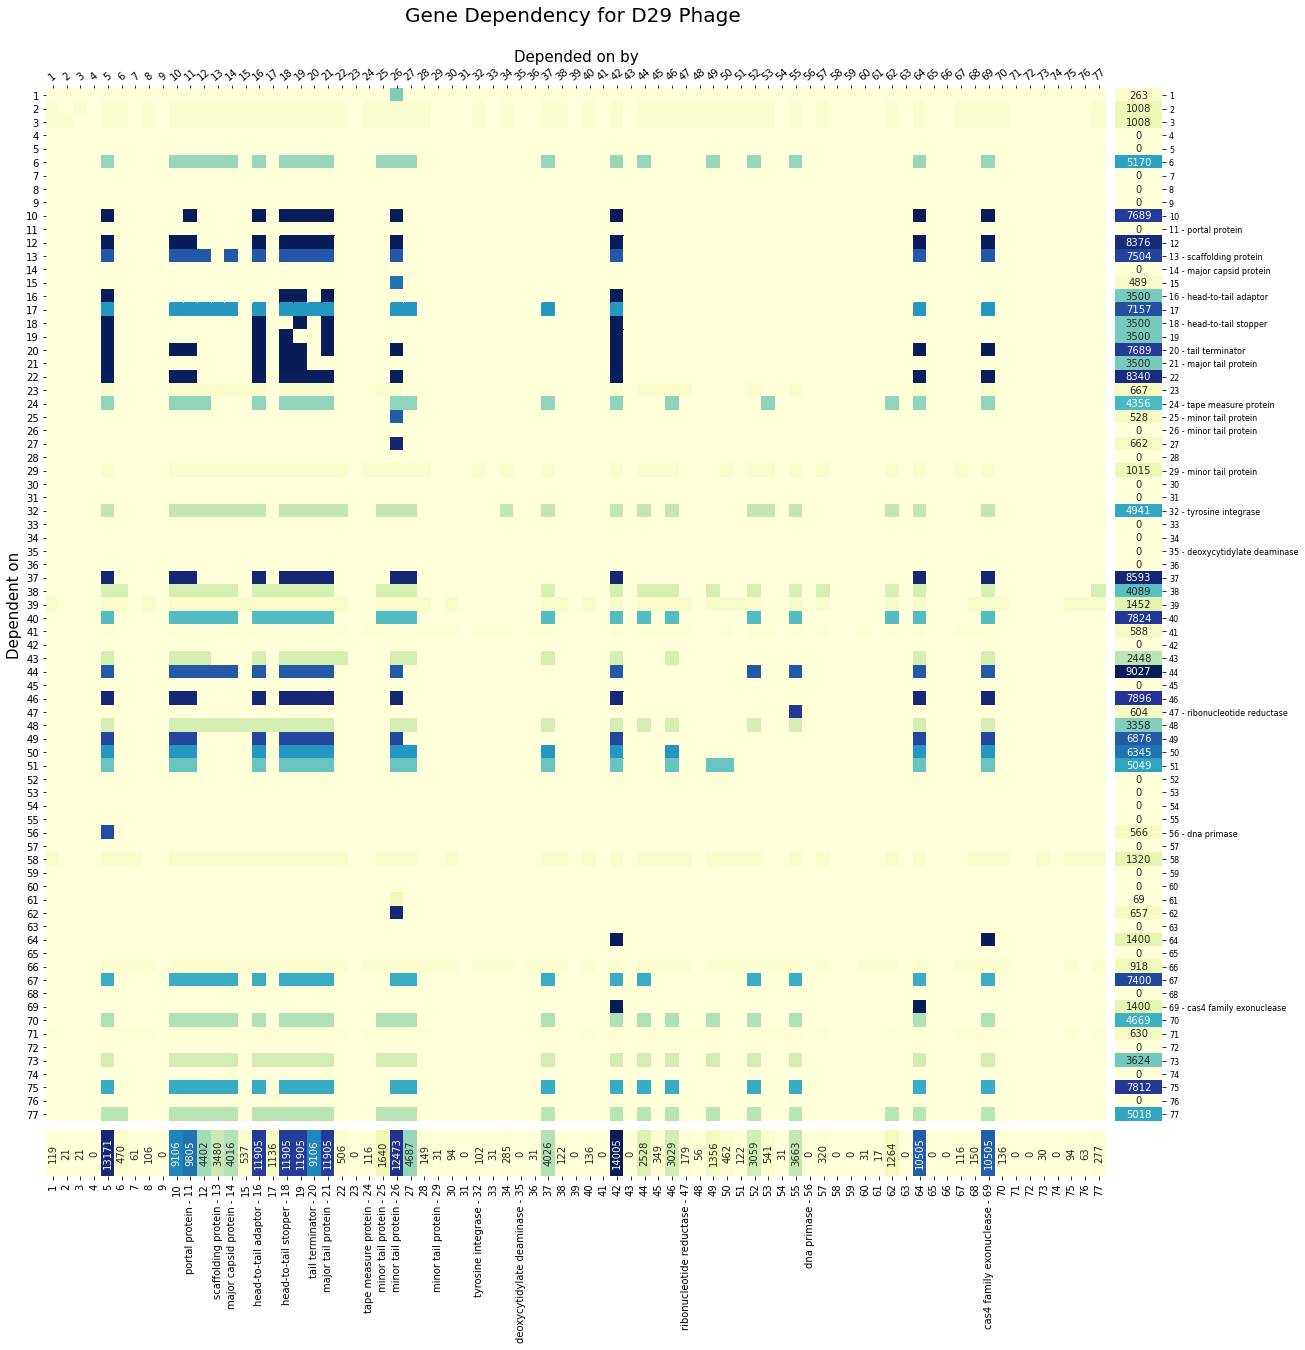

In [67]:
pv = nx.to_numpy_matrix(G, nodelist=sorted(list(phage_genome["gene number"])), dtype = int)
gene_num = list(phage_genome["gene number"])
gene_locs = [int(i)-0.5 for i in gene_num]


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

# mask = np.zeros_like(pv)
# mask[np.tril_indices_from(mask)] = True

sns.heatmap(pv, ax=ax1, cmap="YlGnBu", linecolor='b', cbar = False)
ax1.xaxis.tick_top()
ax1.set_xticks(gene_locs)
ax1.set_xticklabels(sorted(list(phage_genome["gene number"])),rotation=40)
ax1.set_yticks(gene_locs)
ax1.set_yticklabels(sorted(list(phage_genome["gene number"])),rotation=0)

sns.heatmap(np.sum(pv, axis=0, dtype = int), ax=ax2, fmt='d', annot=True, cmap="YlGnBu", cbar=False, xticklabels=True, yticklabels=False,annot_kws={'rotation': 90})
sns.heatmap(np.sum(pv, axis=1, dtype = int), ax=ax3, fmt='d', annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=True)
ax3.yaxis.tick_right()

gene_functions = []
for i in sorted(list(phage_genome["gene number"])):
    function = phage_genome[phage_genome["gene number"]==i]["function"].values[0]
    gene_functions.append(i if function == "NKF" else str(i) + " - " + function)

ax3.set_yticklabels(labels = gene_functions, rotation = 0, fontsize = 8)

gene_functions = []
for i in sorted(list(phage_genome["gene number"])):
    function = phage_genome[phage_genome["gene number"]==i]["function"].values[0]
    gene_functions.append(i if function == "NKF" else function + " - " + str(i))

ax2.set_xticklabels(labels = gene_functions, rotation = 90)

ax1.set_xlabel("Depended on by", fontsize = 15)
ax1.xaxis.set_label_position('top') 

ax1.set_ylabel("Dependent on", fontsize = 15)
ax1.set_title("Gene Dependency for " + target_phage + " Phage \n", fontsize = 20)

plt.show()

In [69]:
G_dep_temp = nx.read_gml("networks/dependency_graph_temperate_"+ str(gene_identifier))
G_dep_lytic = nx.read_gml("networks/dependency_graph_lytic_"+ str(gene_identifier))

In [ ]:
G = nx.DiGraph() # intialize graph

# iterate through all pairs of genes in target phage's genome
for _, row1 in phage_genome.iterrows():
    G.add_node(row1["gene number"], pham = str(row1["pham"]), function = row1["function"])
    pham1 = str(row1["pham"])
    gnum1 = row1["gene number"]
    for _, row2 in phage_genome.iterrows():
        pham2 = str(row2["pham"])
        gnum2 = row2["gene number"]
        #print(previous_pham, curr_pham)
        if gnum1 != gnum2 and G_dep.has_edge(pham1, pham2):
            G.add_edge(gnum1, gnum2, weight = G_dep.edges[pham1,pham2]["weight"])


In [ ]:
pv = nx.to_numpy_matrix(G, nodelist=sorted(list(phage_genome["gene number"])), dtype = int)
gene_num = list(phage_genome["gene number"])
gene_locs = [int(i)-0.5 for i in gene_num]


fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot2grid((20,20), (0,0), colspan=19, rowspan=19)
ax2 = plt.subplot2grid((20,20), (19,0), colspan=19, rowspan=1)
ax3 = plt.subplot2grid((20,20), (0,19), colspan=1, rowspan=19)

# mask = np.zeros_like(pv)
# mask[np.tril_indices_from(mask)] = True

sns.heatmap(pv, ax=ax1, cmap="YlGnBu", linecolor='b', cbar = False)
ax1.xaxis.tick_top()
ax1.set_xticks(gene_locs)
ax1.set_xticklabels(sorted(list(phage_genome["gene number"])),rotation=40)
ax1.set_yticks(gene_locs)
ax1.set_yticklabels(sorted(list(phage_genome["gene number"])),rotation=0)

sns.heatmap(np.sum(pv, axis=0, dtype = int), ax=ax2, fmt='d', annot=True, cmap="YlGnBu", cbar=False, xticklabels=True, yticklabels=False,annot_kws={'rotation': 90})
sns.heatmap(np.sum(pv, axis=1, dtype = int), ax=ax3, fmt='d', annot=True, cmap="YlGnBu", cbar=False, xticklabels=False, yticklabels=True)
ax3.yaxis.tick_right()

gene_functions = []
for i in sorted(list(phage_genome["gene number"])):
    function = phage_genome[phage_genome["gene number"]==i]["function"].values[0]
    gene_functions.append(i if function == "NKF" else str(i) + " - " + function)

ax3.set_yticklabels(labels = gene_functions, rotation = 0, fontsize = 8)

gene_functions = []
for i in sorted(list(phage_genome["gene number"])):
    function = phage_genome[phage_genome["gene number"]==i]["function"].values[0]
    gene_functions.append(i if function == "NKF" else function + " - " + str(i))

ax2.set_xticklabels(labels = gene_functions, rotation = 90)

ax1.set_xlabel("Depended on by", fontsize = 15)
ax1.xaxis.set_label_position('top') 

ax1.set_ylabel("Dependent on", fontsize = 15)
ax1.set_title("Gene Dependency for " + target_phage + " Phage \n", fontsize = 20)

plt.show()

In [56]:
pv

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [21.,  0., 21., ...,  0.,  0., 21.],
        [21., 21.,  0., ...,  0.,  0., 21.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [50]:
np.shape(pv)

(77, 77)

Delete gene depended on by other genes and delete a gene that is not depended on. This could give insight into which genes should be studied more.

Failed Attempts - code in the void 

Text(141.0, 0.5, 'Dependent')

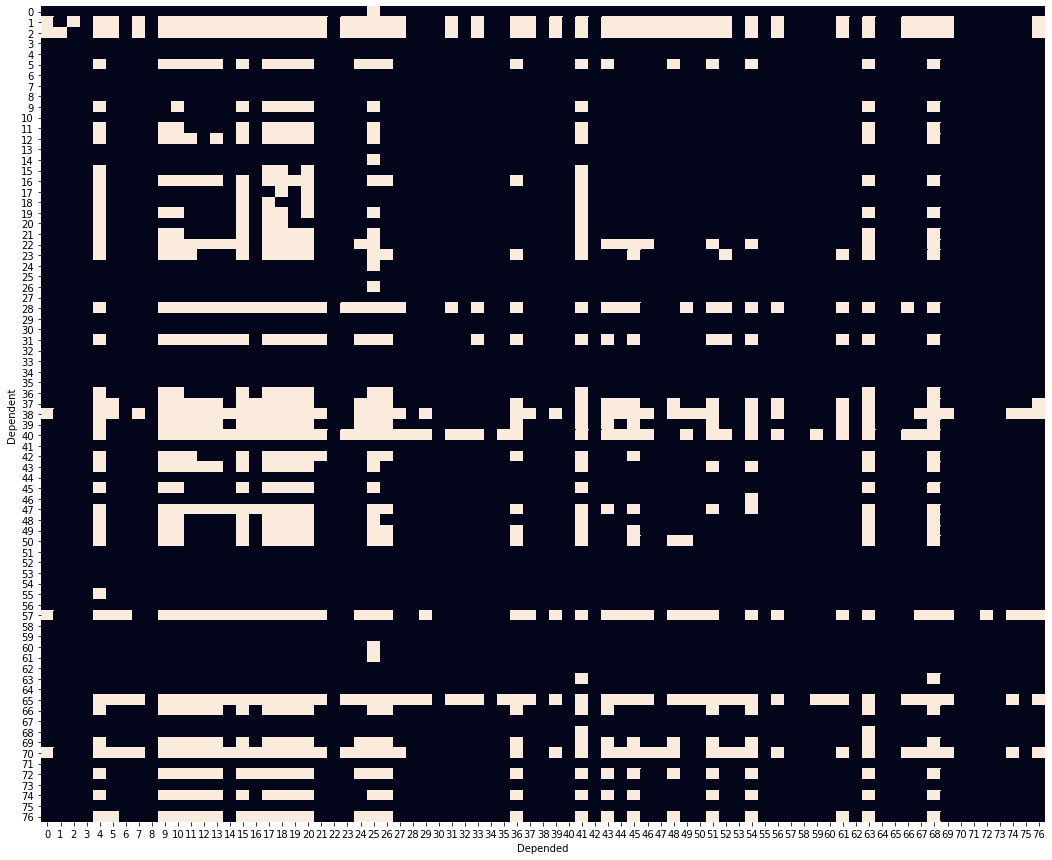

In [51]:
plt.figure(figsize = (18,15))
sns.heatmap(nx.to_numpy_matrix(G, nodelist=sorted(list(phage_genome["gene number"]))), linecolor='b', cbar = False)
plt.xlabel("Depended")
plt.ylabel("Dependent")

In [52]:
G = nx.DiGraph()
gap = 2000
labels = []
pos = {}
genome_length = phage_genome["gene number"].max()
y = 0
for _, row in phage_genome.iterrows():
    labels.append(row["function"])
    G.add_node(row["gene number"])
    x = 20
    pos[row["gene number"]] = [x,y]
    y = y + gap#/genome_length
    if len(labels) > 1:
        G.add_edge(previous_gene_num, row["gene number"])
        sources.append(previous_gene_num)
        targets.append(row["gene number"]-1)
        values.append(1)
        
    previous_gene_num = row["gene number"]
    
plt.figure(figsize = (5,30))

nx.draw_networkx_nodes(G, pos, node_size=100, node_shape = "s")
nx.draw_networkx_edges(G, pos, node_size=100, width=1)
nx.draw_networkx_labels(G,{i:[arr[0]-2,arr[1]] for i,arr in pos.items()}, font_size=14);
#plt.show()
#nx.draw(G, pos=pos, node_size = 100, with_labels = True)

NameError: name 'sources' is not defined

In [ ]:
sources = []
targets = []
values = []
labels = []
xs = []
ys = []
genome_length = phage_genome["gene number"].max()

previous_gene_num = 0
for _, row in phage_genome[phage_genome["gene number"]<10].iterrows():
    labels.append(row["function"])
    xs.append(0.1)
    ys.append(row["gene number"]/genome_length)
    if len(labels) > 1:
        sources.append(previous_gene_num)
        targets.append(row["gene number"]-1)
        values.append(1)
        
        previous_gene_num = targets[-1]


fig = go.Figure(
    go.Sankey(
        arrangement = "fixed",
        node = {
            "label": labels,
            "x": xs,
            "y": ys,
            'pad': 20,
            'thickness': 5
        },
        link = {
            "source": sources,
            "target": targets,
            "value": values
        }))

# fig.update_layout(
#     autosize=False,
#     width=1000,
#     height=1000)

fig.show()

In [ ]:
plt.figure(figsize=(10,5))
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 5,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = "blue"
    ),
    link = dict(
      source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = targets,
      value = values
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()